##  Learning Transfer | Tiny BERT 2

#### Libraries

In [156]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


import torch
from transformers import BertTokenizer
from transformers import T5TokenizerFast
from transformers import AutoModelForSeq2SeqLM
from transformers import BertForSequenceClassification

from transformers import get_linear_schedule_with_warmup

#### Data

In [157]:
data = pd.read_excel('/content/hackaton_result_dataset.xlsx')
print("Data loaded. Rows:", len(data))

Data loaded. Rows: 6508


In [158]:
# split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(data['model_annotation'].tolist(),
                                                                    data['label'].tolist(),
                                                                    test_size=0.1,
                                                                    random_state=1)

# initialise tokenizer
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')

# tokenize data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=32)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=32)

In [159]:
# define custom Dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# create Dataset objects
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

#### Model

In [160]:
# load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=2)

# initialize optimizer
optimizer = AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)

# initialize learning rate scheduler
total_steps = len(train_loader) * 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [161]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [162]:
# early stopping parameters
best_val_loss = float('inf')
patience = 3
trigger_times = 0

#### Training

In [163]:
# training loop
for epoch in range(10):
    model.train()
    total_train_loss = 0

    # process each batch of training data
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # forward pass and loss calculation
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # evaluation mode for model
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    # process each batch of validation data
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass and loss calculation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # prediction and accuracy calculation
            _, predicted = torch.max(outputs.logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.logits[:, 1].cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = 100 * correct / total

    # print training and validation results
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pt')
        trigger_times = 0
    else:
        trigger_times += 1
        # early stopping
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

# print best validation accuracy
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

Epoch 1, Training Loss: 0.6505, Validation Loss: 0.6075, Validation Accuracy: 67.43%
Epoch 2, Training Loss: 0.6016, Validation Loss: 0.5900, Validation Accuracy: 68.66%
Epoch 3, Training Loss: 0.5772, Validation Loss: 0.5844, Validation Accuracy: 69.74%
Epoch 4, Training Loss: 0.5564, Validation Loss: 0.5831, Validation Accuracy: 69.43%
Epoch 5, Training Loss: 0.5366, Validation Loss: 0.5823, Validation Accuracy: 70.51%
Epoch 6, Training Loss: 0.5191, Validation Loss: 0.5853, Validation Accuracy: 70.66%
Epoch 7, Training Loss: 0.5030, Validation Loss: 0.5876, Validation Accuracy: 70.35%
Epoch 8, Training Loss: 0.4930, Validation Loss: 0.5905, Validation Accuracy: 71.12%
Early stopping at epoch 8
Best Validation Accuracy: 70.51%


[Best Model]('https://drive.google.com/file/d/1SAUs13kxiOBFKOdGAIp5YI_nILPi0Dfo/view?usp=share_link')

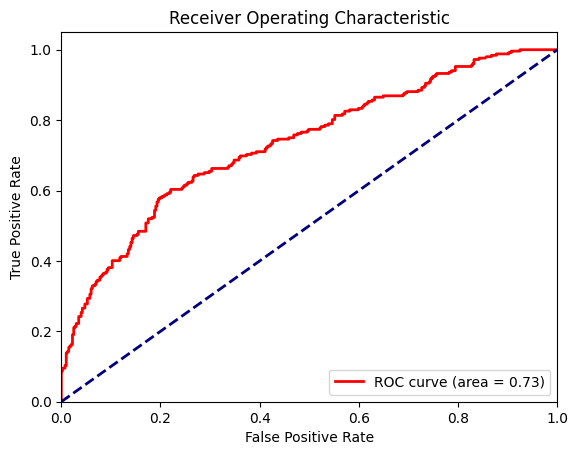

In [164]:
# reload the best model
model.load_state_dict(torch.load('best_model.pt'))

# evaluate on validation set to compute ROC AUC
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.logits[:, 1].cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# plot ROC AUC
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Reference Test

In [173]:
test_data = pd.read_excel('/content/data_part1.xlsx')
print("Data loaded. Rows:", len(test_data))

Data loaded. Rows: 10000


In [174]:
test_texts = test_data['annotation_fastconformer']
test_labels = test_data['label']
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=32)
test_dataset = TextDataset(test_encodings, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

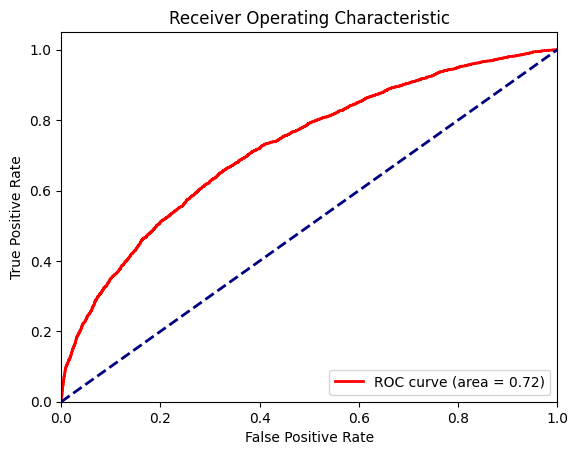

In [175]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.logits[:, 1].cpu().numpy())

# calculate ROC AUC
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# plot ROC AUC
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# # print report
# y_pred = (np.array(all_preds) > 0.5).astype(int)
# print(classification_report(all_labels, y_pred))

## Text Correction | T5

In [168]:
# # model
# spell_model = 'UrukHan/t5-russian-spell'

In [169]:
# # load model and tokenizer
# try:
#     spell_tokenizer = T5TokenizerFast.from_pretrained(spell_model)
#     spell_model = AutoModelForSeq2SeqLM.from_pretrained(spell_model)
#     print("Model and tokenizer loaded.")
# except Exception as e:
#     print("Error loading model or tokenizer:", e)

In [170]:
# # function to correct spelling
# def correct_spelling(row):
#     try:
#         text = row['model_annotation']
#         index = row.name
#         task_prefix = "Spell correct: "
#         encoded = spell_tokenizer(
#             task_prefix + text,
#             padding="max_length",
#             max_length=256,
#             truncation=True,
#             return_tensors="pt",
#         )
#         predicts = spell_model.generate(encoded['input_ids'])
#         corrected_text = spell_tokenizer.decode(predicts[0], skip_special_tokens=True)
#         if index % 10 == 0:  # show progress every 10 rows
#             print(f"Processed row {index}")
#         return corrected_text
#     except Exception as e:
#         print(f"Error in spelling correction for row {index}: {text}", e)
#         return text

In [171]:
# # apply correction to 'model_annotation' column
# if 'model_annotation' in data.columns:
#     data['corrected_annotation'] = data.apply(correct_spelling, axis=1)
#     print("Spelling correction done.")
# else:
#     print("'model_annotation' column not in data.")

In [172]:
# # save as .csv
# output_file_path = '/content/corrected_data.csv'
# data.to_csv(output_file_path, index=False)